# Incremental Algorithms Problem Set (50 points)

In this problem set, you will implement the ARA* algorithm, an anytime heuristic search that tunes its performance bound based on available search time. The algorithm begins by finding a suboptimal solution quickly using a loose bound and then progressively tightens the bound until time runs out. With enough time, it finds a provably optimal solution. In addition, while improving its bound, ARA* reuses previous search efforts, which makes it significantly more efficient.

Make sure you load the dependencies below.

In [ ]:
# Requirements: python=3.9+ numpy matplotlib jupyter ipython ipympl pylint ipywidgets nose
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
%matplotlib widget

import numpy as np
from utils import (State, ARAStar_Plotter, ARAStar_Planner,
                   GRAPH_LARGE, GRAPH_SMALL)
import tests

# Conceptual Questions

## Problem 1 (2 pts) 

Why might we prefer to find a suboptimal solution over an optimal solution? Can you name a hypothetical example in which this would be the case.
<br/>
<div class="alert alert-info">Please type your answer below.</div>

Suboptimal solution is always faster, and often not that much worse than the optimal solution. The less complex the obstacles are, the closer the suboptimal solution will be to the optimal one. As well, if no solution at all, the optimal solution will take a very long time to realize the results, while the suboptimal solution can find the result quickly.

## Problem 2 (2 pts) 
In the following figure, the left three columns correspond to A* searches with decreasing $\epsilon$ and the right three columns correspond to ARA* search iterations with decreasing $\epsilon$. The shaded cells represent cells that have been expanded. Why are there fewer cells expanded in the ARA* algorithm? 
<img src="ara_star_iterations.png" />
<br/>
<div class="alert alert-info">Please type your answer below.</div>

ARA* remembers results from the previous runs: before the start of a new ComputePath( ) run in ARA*, all of the locally inconsistent states (state's g-value is decreased) are moved into the OPEN set. Only the OPEN set states will be expanded to. This means that the locally consistent states are already the best predecessors that lead up to the beginning of the inconsistent states in a path. Therefore, the locally consistent states will not be expanded to again. Regular Weighted A* on the other hand, starts over from scratch for each $\epsilon$ and has to expand those states again.

# Specification of ARA* Planner

We have created a class called `ARAStar_Planner` with several data structures and utility methods that are helpful in performing the ARA* algorithm. We have also provided some additional utilies for serializing the state of the algorithm for visualization purposes. We recommend you take a look at `ara_star.py` to understand how these methods work. 

The `ARAStar_Planner` class is initialized as follows:
    
    ARAStar_Planner(graph, start, goal, epsilon, stepsize)
    
where the arguments are:
- `graph` [np.ndarray] - _graph to search through comprised of only 0s and 1s, with 0s representing free space and 1s representing obstacles_
- `start` [State] - _start coordinate of the search_
- `goal` [State] - _goal coordinate of the search_
- `epsilon` [float] - _initial inflation factor for the heuristic function_
- `stepsize` [float] - _amount to decrease epsilon by each iteration of ARA*_

All of the above are stored as attributes within the `ARAStar_Planner` class. The class additionally has these attributes, some of which you might want to utilize in the functions you write later in this problem set:
- `g` [dict{State: float}] - _mapping of `State` instances to the cost from the start state to the given state_
- `OPEN` [dict{State: float}] - _mapping locally inconsistent `States` to their respective fvalues; used as a priority queue for ARA* search_
- `CLOSED` [set{State}] - _`States` which have been expanded_
- `INCONS` [set{State}] - _locally inconsistent `States` which have been previously expanded_
- `PARENTS` [dict{State: State}] - _mapping of each expanded State to its predecessor State in the graph_
- `alg_history` [dict{float: List[ARAStar_State]}] - _mapping of an epsilon value to a list of ARAStar_State objects, which recreate the state of the algoritm as it progressed through its search_

Note that `State` objects represent coordinates on our grid. We can initialize the coordinate `(x, y)` as `State(x, y)`. For example, `(5, 6)` would correspond to `State(5, 6)`. 



We have also provided the following methods in the `ARAStar_Planner` class for you to use. Check out `ara_star.py` to see the implementation.
- `h(self, state: State) -> int` - Euclidean heuristic between goal and state
- `f(self, state: State) -> float` - Combined inflated heuristic
- `is_clear(self, state: State) -> bool` - Returns True if given state does not collide with an obstacle in the graph, False otherwise
- `is_obstacle(self, state: State) -> bool` - Returns True if given state collides with an obstacle in the graph, False otherwise.
- `valid_state(self, state: State) -> bool` - Returns True if given state is within bounds of graph and does not collide with an obstacle, False otherwise.
- `neighbors(self, state: State) -> list[State]` - Returns list of neighbors of the given state which are within the bounds of the 8-connected graph and which do not collide with obstacles.
- `cost(self, state1: State, state2: State) -> float` - Cost of traversal between two states. Infinite if states are not neighbors, else Euclidean distance.
- `get_next_state(self) -> State` - Returns the state from OPEN with the lowest f value, which should be expanded next, or None if OPEN is empty
- `extract_path(self, final_state: State = None) -> list[State]` - From PARENTS mapping, returns path to final_state as a list of States. If final_state is None, defaults to goal state
- `publish_path(self)` - Saves current value of epsilon and current path to set of paths found
- `save_alg_state(self, current_state: State)` - Extracts and saves current path and values of OPEN, CLOSED, and INCONS states to algorithm history for use in testing and plotting
        

# Implementing ARA*

Below you will implement the `initialize`, `improve_path`, `calc_epsilon_prime`, and `run` methods. We've included testing code for each method so you can implement them one at a time, but the tests build on each other so be sure to go in order! Each of these methods is based on the pseudocode from the original ARA* paper (included), with some additions to make it visualize and test our inputs. Use the following pseudocode to guide your implementation:

<br/>
<img src="pseudocode_1.png" width=500/>
<img src="pseudocode_2.png" width=500/>

## Initializing the ARA* Planner (5 pts)

Implement a function that will take an `ARAStar_Planner` object and initialize its fields to perform the ARA* algorithm. 

<br/>
<div class="alert alert-info">
Please implement the following function.
</div>

In [ ]:
def initialize(planner: ARAStar_Planner):
    planner.g[planner.goal] = np.inf
    planner.g[planner.start] = 0
    planner.OPEN.clear()
    planner.CLOSED.clear()
    planner.INCONS.clear()
    planner.PARENTS.clear()
    planner.OPEN[planner.start] = planner.f(planner.start)
    planner.PARENTS[planner.start] = planner.start
    planner.alg_history.clear()
    planner.paths_found.clear()

Let's test the function!

In [ ]:
tests.test_initalize(initialize)

Tests passed!!

## Improving the Existing Path (15 pts) 

Implement a function that will take an `ARAStar_Planner` object and improve the existing stored path by updating the current state of the vertices using an updated value of $\epsilon$. 

<br/>
<div class="alert alert-info">
Please implement the following function.
</div>

In [ ]:
def improve_path(planner: ARAStar_Planner):
    planner.save_alg_state(planner.start)
    while planner.f(planner.goal)>min(planner.f(s) for s in planner.OPEN):
        s = planner.get_next_state()
        planner.OPEN.pop(s)
        planner.CLOSED.add(s)
        for s_prime in planner.neighbors(s):
            if s_prime not in planner.g:
                planner.g[s_prime] = np.inf
            new_cost = planner.g[s] + planner.cost(s, s_prime)
            if planner.g[s_prime] > new_cost:
                planner.g[s_prime] = new_cost
                planner.PARENTS[s_prime] = s
                if s_prime not in planner.CLOSED:
                    planner.OPEN[s_prime]  = planner.f(s_prime)
                else:
                    planner.INCONS.add(s_prime)
        planner.save_alg_state(s)

Let's test the function!

In [ ]:
tests.test_improve_path(improve_path, initialize)

Tests passed!!

## Calculating $\epsilon^{'}$ (6 pts) 

A sub-optimality bound can also be computed as the ratio between $g(s_{goal})$, which gives an upper bound on the cost of an optimal solution, and the minimum un-weighted $f$-value of a locally inconsistent state, which gives a lower bound on the cost of an optimal solution. Thus, the actual sub-optimality bound for ARA* is computed as the minimum between ε and this ratio, which we label as $\epsilon^{'}$. Implement a function below that will take an `ARAStar_Planner` object and compute the value of $\epsilon^{'}$.

<br/>
<div class="alert alert-info">
Please implement the following function.
</div>

In [ ]:
def calc_epsilon_prime(planner: ARAStar_Planner):
    return min(planner.epsilon, planner.g[planner.goal] / min( planner.g[s] + planner.h(s) for s in list(planner.OPEN) + list(planner.INCONS)))

Let's test the function!

In [ ]:
tests.test_calc_epsilon_prime(calc_epsilon_prime, improve_path, initialize)

Tests passed!!

## Running ARA* (15 pts) 

Implement a function that will take an `ARAStar_Planner` object and run the ARA* algorithm for a sequence of $\epsilon$ values, beginning at the value initially inputted when initializing the object and ending at 1 (optimal solution).

<br/>
<div class="alert alert-info">
Please implement the following function.
</div>

In [20]:
def run(planner: ARAStar_Planner):
    initialize(planner)
    improve_path(planner)
    epsilon_prime = calc_epsilon_prime(planner)
    planner.publish_path()
    while epsilon_prime > 1:
        planner.epsilon = max(planner.epsilon - planner.stepsize, 1)
        for s in planner.OPEN:
            planner.OPEN[s] = planner.f(s)
        for s in planner.INCONS:
            planner.OPEN[s] = planner.f(s)
        planner.INCONS.clear()
        planner.CLOSED.clear()
        improve_path(planner)
        epsilon_prime = calc_epsilon_prime(planner)
        planner.publish_path()

Let's test the function!

In [21]:
tests.test_run(run)

Tests passed!!

# Visualization 
Now that we've verified our implementation, let's see how it works in action, by visualizing how the search progresses along a graph with a two different potential paths for different values of $\epsilon$.

In [22]:
EPSILON = 2.5
START = State(0, 0)
GOAL = State(6, 5)

planner = ARAStar_Planner(GRAPH_SMALL, START, GOAL, EPSILON, stepsize=1)
plotter = ARAStar_Plotter(GRAPH_SMALL, START, GOAL)
run(planner)

Use the arrows in the widget to see how the states of the cells change as the search process progresses. You can also view how the shortest path changes over time. 

In [23]:
plotter.plot_episode(2.5, planner.alg_history[2.5])

In [24]:
plotter.plot_episode(1.5, planner.alg_history[1.5])

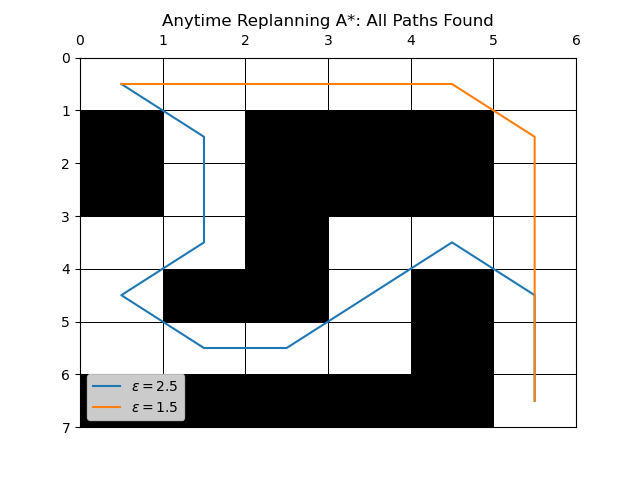

In [25]:
plotter.plot_paths_found(planner.paths_found)

## Applying ARA* to Larger Graphs with Multiple Branches

Now lets try applying our planner to larger regions where there might be many different paths we can take.

In [26]:
EPSILON = 1.5
START = State(24, 4)
GOAL = State(4, 44)

planner = ARAStar_Planner(GRAPH_LARGE, START, GOAL, EPSILON, stepsize=0.2)
plotter = ARAStar_Plotter(GRAPH_LARGE, START, GOAL)
run(planner)

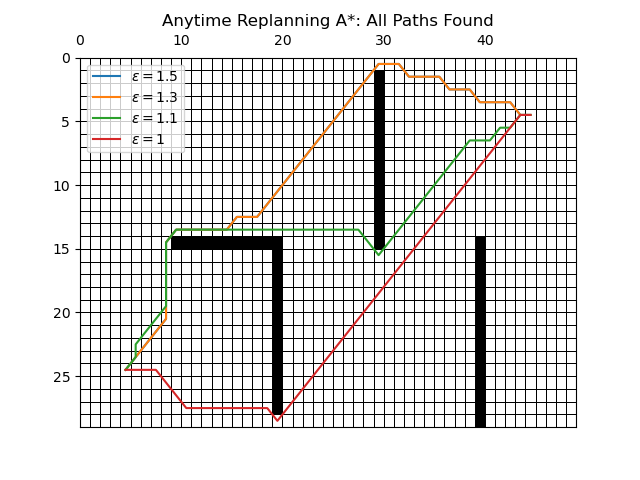

In [27]:
plotter.plot_paths_found(planner.paths_found)

## Path Analysis (5 pts)
Why does the graph look like this? How does changing $\epsilon$ affect the path?

<br/>
<div class="alert alert-info">Please type your answer below.</div>

Epsilon affects the heuristic weight, which means that the expansion of states (and ultimately the path) will be biased towards the Chevychev heuristic in use. For example, in the south-west part of the graph above, as the goal is north-east of the starting point, the heuristic focuses and guides the expansion to go north, although the optimal path needs to go south first to avoid the obstacle (which is initially counter-intuitive to the bias). As epsilon approaches 1, the search expands in a broad arc covering a wide range of expansions, while moving generally in the direction of the goal. As epsilon increases, the search expands narrowly towards the goal, and maintains its focus in the direction of the goal. 